# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [2]:
#! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prettytable

# Tensorflow for CPU users
#! pip install tensorflow

In [3]:
import itertools
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os, joblib
import openpyxl
import tensorflow as tf
import keras
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox

# Deep learning
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [4]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

## 2. Importing Final Datasts

In [5]:
# === Path to saved datasets ===
data_path = Path("final_datasets")

# === Read datasets (with Date as index) ===
final_df = pd.read_csv(data_path / "final_df.csv", index_col=0, parse_dates=True)
final_df_scaled = pd.read_csv(data_path / "final_df_scaled.csv", index_col=0, parse_dates=True)

print("Datasets loaded successfully:")
print("final_df shape:", final_df.shape)
print("final_df_scaled shape:", final_df_scaled.shape)

Datasets loaded successfully:
final_df shape: (243, 44)
final_df_scaled shape: (243, 43)


## 3. Feature Importance and Selection

### a. Dataset Split

In [6]:
# For Scaled Data
X_scaled = final_df_scaled.drop(columns=['Sales (Rmn)', 'Volume'])
y1_scaled = final_df_scaled['Sales (Rmn)']
y2_scaled = final_df_scaled['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X_scaled):
    X_train_scaled, X_test_scaled = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y1_train_scaled, y1_test_scaled = y1_scaled.iloc[train_idx], y1_scaled.iloc[test_idx]
    y2_train_scaled, y2_test_scaled = y2_scaled.iloc[train_idx], y2_scaled.iloc[test_idx]


# For Raw Data
X = final_df.drop(columns=['Sales (Rmn)', 'Volume'])
y1 = final_df['Sales (Rmn)']
y2 = final_df['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y1_train, y1_test = y1.iloc[train_idx], y1.iloc[test_idx]
    y2_train, y2_test = y2.iloc[train_idx], y2.iloc[test_idx]

### b. Correlation Heatmap

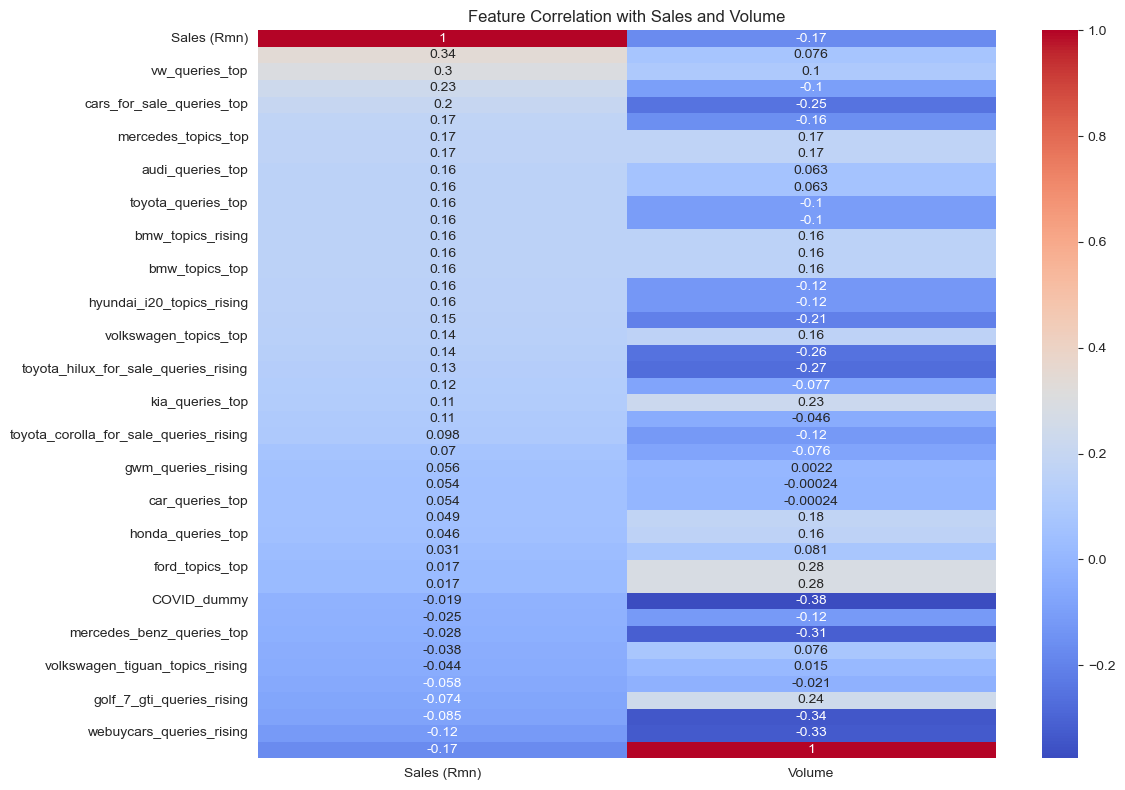

In [7]:
# Check correlations with Sales and Volume
correlation = final_df.corr(numeric_only=True)

# Heatmap of correlations with Sales and Volume
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['Sales (Rmn)', 'Volume']].sort_values(by='Sales (Rmn)', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Sales and Volume")
plt.tight_layout()
plt.show()

### c. Feature Importance/Selection

In [8]:
# Feature filtering function
def filter_features_by_importance(X, y, threshold=0.001, n_estimators=200, n_repeats=30, random_state=42):
    # Fit RandomForest model
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)

    # Compute Permutation Importance
    pfi = permutation_importance(rf, X, y, n_repeats=n_repeats, random_state=random_state)

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': pfi.importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Filter features based on threshold
    important_features = importance_df[importance_df['Importance'] > threshold]['Feature']
    X_filtered = X[important_features]

    # Reporting
    print(f"\nNumber of features before filtering: {X.shape[1]}")
    print(f"Number of features after filtering: {X_filtered.shape[1]}")
    print(f"Number of features dropped: {X.shape[1] - X_filtered.shape[1]}")
    print("="*50)
    print("Permutation Feature Importance Table:")
    X_filtered.info()

    return X_filtered

In [9]:
X1_train = filter_features_by_importance(X_train, y1_train, threshold=0.01)
X1_test = X_test[X1_train.columns]
X1_train_scaled = X_train_scaled[X1_train.columns]
X1_test_scaled = X_test_scaled[X1_train.columns]


Number of features before filtering: 42
Number of features after filtering: 17
Number of features dropped: 25
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2005-02-28 to 2021-12-31
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   webuycars_queries_top       203 non-null    int64
 1   vw_queries_top              203 non-null    int64
 2   nissan_queries_top          203 non-null    int64
 3   cars_for_sale_queries_top   203 non-null    int64
 4   webuycars_queries_rising    203 non-null    int64
 5   autotrader_queries_top      203 non-null    int64
 6   volkswagen_topics_top       203 non-null    int64
 7   hyundai_queries_top         203 non-null    int64
 8   gwm_queries_rising          203 non-null    int64
 9   honda_queries_top           203 non-null    int64
 10  golf_7_gti_queries_rising   203 non-null    int64
 11  mercede

In [10]:
X2_train = filter_features_by_importance(X_train, y2_train, threshold=0.01)
X2_test = X_test[X2_train.columns]
X2_train_scaled = X_train_scaled[X2_train.columns]
X2_test_scaled = X_test_scaled[X2_train.columns]


Number of features before filtering: 42
Number of features after filtering: 12
Number of features dropped: 30
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2005-02-28 to 2021-12-31
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   cars_queries_top            203 non-null    int64
 1   autotrader_queries_top      203 non-null    int64
 2   suzuki_queries_top          203 non-null    int64
 3   cars_for_sale_queries_top   203 non-null    int64
 4   ford_queries_top            203 non-null    int64
 5   opel_queries_top            203 non-null    int64
 6   ford_topics_top             203 non-null    int64
 7   hyundai_queries_top         203 non-null    int64
 8   honda_queries_top           203 non-null    int64
 9   gwm_queries_rising          203 non-null    int64
 10  hyundai_i10_queries_rising  203 non-null    int64
 11  golf_6_

## 7. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA</td>
      <td>An extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. It captures both short-term and long-term dependencies within the data</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>A variant of the regression version of the Support Vector Machines (SVM). It tries to fit a function that predicts future values while keeping prediction errors within a certain margin (ε-insensitive loss function).</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>A type of neural network that excels in this area. Unlike simple models, LSTMs can remember information for long periods, making them ideal for time series tasks where past data influences future values.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BI-LSTM</td>
      <td>An Extension of the LSTM model that integrates the input information from both past and future time steps. It's like predicting the middle words of a sentence by knowing both its first and last words.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines the CNNs power of learning local patterns in data, with the LSTMs ability to capture long-term dependencies in sequential data.</td>
      <td>Deep Learning</td>
    </tr>
  </tbody>
</table>

### a. Helper Functions

In [17]:
# --- Lag features (unchanged) ---
def create_lags(y, lags=12):
    df = pd.DataFrame({'y': y})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    return df.dropna()

def create_multivariate_lags(X, y, lags=12):
    X_lagged, y_lagged = [], []
    for i in range(lags, len(X)):
        X_lagged.append(X[i-lags:i, :])
        y_lagged.append(y[i])
    return np.array(X_lagged), np.array(y_lagged)

# --- NEW: build rolling test windows that cover the full test horizon ---
def build_test_windows_from_exog(X_train_full, X_test_full, lags):
    n_features = X_train_full.shape[1]
    # Seed with last `lags` rows of train exog, then append all test exog
    seed_plus_test = np.vstack([X_train_full[-lags:, :], X_test_full])
    windows = []
    for i in range(len(X_test_full)):
        # Window i: rows [i : i+lags]
        windows.append(seed_plus_test[i:i+lags, :])
    return np.array(windows)  # [len(test), lags, n_features]

# --- NEW: direct multivariate prediction for test horizon ---
def predict_nn_multivariate_direct(model, X_train_full, X_test_full, lags):
    X_test_windows = build_test_windows_from_exog(X_train_full, X_test_full, lags)
    preds = model.predict(X_test_windows, verbose=0).flatten()
    return preds

# --- AIC/BIC + metrics (unchanged) ---
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2*k - 2*loglik
    bic = np.log(n)*k - 2*loglik
    return aic, bic

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true)))

def evaluate_model(name, y_true, y_pred, k):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)   # <--- NEW METRIC
    aic, bic = calculate_aic_bic(y_true, y_pred, k)
    
    return [name,
            f"{aic:.3f}", f"{bic:.3f}",
            f"{rmse:.3f}", f"{mae:.3f}", f"{mape:.3f}", f"{r2:.3f}"]

def compute_residual_ci(y_true, y_pred, alpha=0.05):
    resid = y_true - y_pred
    std = np.std(resid)
    lower = y_pred - 1.96 * std
    upper = y_pred + 1.96 * std
    return lower, upper

# --- SARIMA / SARIMAX (unchanged) ---
def train_sarima(y, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    ci = forecast_obj.conf_int()
    return results, forecast, ci

def train_sarimax(y, exog, exog_future, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps, exog=exog_future)
    forecast = forecast_obj.predicted_mean
    ci = forecast_obj.conf_int()
    return results, forecast, ci

# --- SVR (unchanged) ---
def train_svr(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    model = SVR(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    return model, forecast

def train_svr_multivariate(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    model = SVR(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    return model, forecast

# --- Neural networks (architectures unchanged) ---
def build_model(model_type, input_shape, units=64, filters=64, kernel_size=3, pool_size=2, lr=0.001, dropout=0.2):
    model = Sequential()
    if model_type == "lstm":
        model.add(LSTM(units, activation="tanh", return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(units//2, activation="tanh"))
    elif model_type == "bilstm":
        model.add(Bidirectional(LSTM(units, activation="tanh", return_sequences=True), input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(Bidirectional(LSTM(units//2, activation="tanh")))
    elif model_type == "cnnlstm":
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape))
        model.add(Conv1D(filters=filters//2, kernel_size=2, activation="relu"))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))
        model.add(LSTM(units, activation="tanh", return_sequences=True))
        model.add(LSTM(units//2, activation="tanh"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# --- Univariate NN training (unchanged) ---
def train_nn_univariate(y_train, y_test, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    train_df = create_lags(y_train, lags)
    X_train = train_df.drop("y", axis=1).values.reshape(-1, lags, 1)
    y_train_lag = train_df["y"].values
    model = build_model(model_type, (lags, 1), **kwargs)
    model.fit(X_train, y_train_lag, epochs=epochs, batch_size=batch_size, verbose=0)
    forecast = []
    last_window = y_train[-lags:].tolist()
    for _ in range(len(y_test)):
        X_pred = np.array(last_window[-lags:]).reshape(1, lags, 1)
        y_pred = model.predict(X_pred, verbose=0)[0,0]
        forecast.append(y_pred)
        last_window.append(y_pred)
    return model, np.array(forecast)

# --- Multivariate NN training (train on lagged; predict on rolling windows) ---
def train_nn_multivariate_direct(X_train_lagged, y_train_lagged, X_train_full, X_test_full,
                                 model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Train on lagged multivariate exogenous inputs (X_train_lagged) and predict
    across the full test horizon by building rolling windows from exogenous features.
    """
    timesteps, features = X_train_lagged.shape[1], X_train_lagged.shape[2]
    assert timesteps == lags, "Lag dimension mismatch."

    # Build & fit
    model = build_model(model_type, (timesteps, features), **kwargs)
    model.fit(X_train_lagged, y_train_lagged, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict across the complete test horizon
    preds = predict_nn_multivariate_direct(model, X_train_full, X_test_full, lags)
    return model, preds


### b. Sales

#### i. Model Building

In [18]:
# --- Convert to NumPy arrays ---
y1_train_np = y1_train_scaled.values if hasattr(y1_train_scaled, "values") else y1_train_scaled
y1_test_np  = y1_test_scaled.values  if hasattr(y1_test_scaled,  "values") else y1_test_scaled
X1_train_np = X1_train_scaled.values if hasattr(X1_train_scaled, "values") else X1_train_scaled
X1_test_np  = X1_test_scaled.values  if hasattr(X1_test_scaled,  "values") else X1_test_scaled

# --- Parameters ---
lags = 12
epochs = 30
batch_size = 8

# --- Create multivariate lagged input for NNs (TRAIN ONLY) ---
X_train_nn, y_train_nn = create_multivariate_lags(X1_train_np, y1_train_np, lags)
# DO NOT create lagged test for NN prediction; we'll build rolling windows instead

results = []

# === SARIMA (Univariate) ===
sarima_res, sarima_forecast, sarima_ci = train_sarima(y1_train_np, steps=len(y1_test_np))
results.append(evaluate_model("SARIMA", y1_test_np, sarima_forecast, k=3))

# === SARIMAX (Multivariate) ===
sarimax_res, sarimax_forecast, sarimax_ci = train_sarimax(y1_train_np, X1_train_np, X1_test_np, steps=len(y1_test_np))
results.append(evaluate_model("SARIMAX", y1_test_np, sarimax_forecast, k=3 + X1_train_np.shape[1]))

# === LSSVR (Univariate, first feature) ===
lssvr_model, lssvr_forecast = train_svr(X1_train_np[:, :1], y1_train_np, X1_test_np[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y1_test_np, lssvr_forecast)
results.append(evaluate_model("LSSVR-Uni", y1_test_np, lssvr_forecast, k=1))

# === LSSVR (Multivariate) ===
lssvr_mv_model, lssvr_mv_forecast = train_svr_multivariate(X1_train_np, y1_train_np, X1_test_np)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y1_test_np, lssvr_mv_forecast)
results.append(evaluate_model("LSSVR-Multi", y1_test_np, lssvr_mv_forecast, k=X1_train_np.shape[1]))

# === LSTM (Univariate) ===
lstm_model, lstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="lstm",
                                                lags=lags, epochs=epochs, batch_size=batch_size)
lstm_lower, lstm_upper = compute_residual_ci(y1_test_np, lstm_forecast)
results.append(evaluate_model("LSTM-Uni", y1_test_np, lstm_forecast, k=lags+50))

# === LSTM (Multivariate) — train on lagged TRAIN, predict over full TEST horizon ===
lstm_mv_model, lstm_mv_forecast = train_nn_multivariate_direct(
    X_train_nn, y_train_nn, X1_train_np, X1_test_np,
    model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size
)
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y1_test_np, lstm_mv_forecast)
results.append(evaluate_model("LSTM-Multi", y1_test_np, lstm_mv_forecast, k=X1_train_np.shape[1]))

# === BiLSTM (Univariate) ===
bilstm_model, bilstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="bilstm",
                                                    lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_lower, bilstm_upper = compute_residual_ci(y1_test_np, bilstm_forecast)
results.append(evaluate_model("BiLSTM-Uni", y1_test_np, bilstm_forecast, k=lags+50))

# === BiLSTM (Multivariate) ===
bilstm_mv_model, bilstm_mv_forecast = train_nn_multivariate_direct(
    X_train_nn, y_train_nn, X1_train_np, X1_test_np,
    model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size
)
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y1_test_np, bilstm_mv_forecast)
results.append(evaluate_model("BiLSTM-Multi", y1_test_np, bilstm_mv_forecast, k=X1_train_np.shape[1]))

# === CNN-LSTM (Univariate) ===
cnnlstm_model, cnnlstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="cnnlstm",
                                                      lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y1_test_np, cnnlstm_forecast)
results.append(evaluate_model("CNN-LSTM-Uni", y1_test_np, cnnlstm_forecast, k=lags+50+64))

# === CNN-LSTM (Multivariate) ===
cnnlstm_mv_model, cnnlstm_mv_forecast = train_nn_multivariate_direct(
    X_train_nn, y_train_nn, X1_train_np, X1_test_np,
    model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size
)
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y1_test_np, cnnlstm_mv_forecast)
results.append(evaluate_model("CNN-LSTM-Multi", y1_test_np, cnnlstm_mv_forecast, k=X1_train_np.shape[1]))

# --- Results tables (unchanged aside from using y1_test_np consistently) ---
uni_models   = ["SARIMA", "LSSVR-Uni", "LSTM-Uni", "BiLSTM-Uni", "CNN-LSTM-Uni"]
multi_models = ["SARIMAX", "LSSVR-Multi", "LSTM-Multi", "BiLSTM-Multi", "CNN-LSTM-Multi"]

table_uni = PrettyTable();  table_uni.field_names   = ["Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R²"]
table_multi = PrettyTable(); table_multi.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R²"]

for res in results:
    (table_uni if res[0] in uni_models else table_multi).add_row(res)

print("\n=== Univariate Model Performance ===");   print(table_uni)
print("\n=== Multivariate Model Performance ==="); print(table_multi)



=== Univariate Model Performance ===
+--------------+----------+----------+-------+-------+--------+---------+
|    Model     |   AIC    |   BIC    |  RMSE |  MAE  |  MAPE  |    R²   |
+--------------+----------+----------+-------+-------+--------+---------+
|    SARIMA    | -149.670 | -144.603 | 0.053 | 0.045 | 10.539 |  -0.945 |
|  LSSVR-Uni   | -146.142 | -144.453 | 0.050 | 0.042 | 6.886  |  -0.713 |
|   LSTM-Uni   | -18.298  |  86.413  | 0.060 | 0.048 | 15.341 |  -1.527 |
|  BiLSTM-Uni  |  43.784  | 148.494  | 0.130 | 0.101 | 41.482 | -10.700 |
| CNN-LSTM-Uni | 107.882  | 320.681  | 0.071 | 0.059 | 16.700 |  -2.494 |
+--------------+----------+----------+-------+-------+--------+---------+

=== Multivariate Model Performance ===
+----------------+----------+---------+-------+-------+--------+--------+
|     Model      |   AIC    |   BIC   |  RMSE |  MAE  |  MAPE  |   R²   |
+----------------+----------+---------+-------+-------+--------+--------+
|    SARIMAX     | -113.074 | -79.

#### ii. Plots

In [19]:
fig_uni = go.Figure()

# Actual data
fig_uni.add_trace(go.Scatter(
    x=y1_scaled.index,
    y=y1_scaled,
    mode='lines',
    name='Actual',
    line=dict(width=2, color='#0073CF'),
    legendgroup="Actual"
))

last_train_x = y1_train_scaled.index[-1]
last_train_y = y1_train_scaled.values[-1]

# Univariate forecasts
models_uni = {
    "SARIMA": (sarima_forecast, sarima_ci),
    "LSSVR-Uni": (lssvr_forecast, (lssvr_lower, lssvr_upper)),
    "LSTM-Uni": (lstm_forecast, (lstm_lower, lstm_upper)),
    "BiLSTM-Uni": (bilstm_forecast, (bilstm_lower, bilstm_upper)),
    "CNN-LSTM-Uni": (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))
}

colors = [
    "#007BA7",  # Brandeis Blue
    "#FFD300",  # Sunny
    "#FFE135",  # Banana Yellow
    "#E32636",  # Spanish Red
    "#A51C30"   # Harvard Crimson
]

for i, (name, (forecast, ci)) in enumerate(models_uni.items()):
    # Handle confidence intervals
    if isinstance(ci, tuple):
        lower, upper = np.array(ci[0]), np.array(ci[1])
    elif isinstance(ci, np.ndarray):
        lower, upper = ci[:, 0], ci[:, 1]
    else:  # DataFrame
        lower, upper = ci.iloc[:, 0].values, ci.iloc[:, 1].values

    # Forecast line
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y1_test_scaled.index),
        y=[last_train_y] + list(forecast),
        mode='lines',
        name=name,
        line=dict(color=colors[i]),
        legendgroup=name
    ))

    # Confidence interval (fill)
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y1_test_scaled.index),
        y=[last_train_y] + list(upper),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y1_test_scaled.index),
        y=[last_train_y] + list(lower),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))

fig_uni.update_layout(
    title='Sales Forecast - Univariate Models',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white'
)
fig_uni.show()


In [20]:
fig_multi = go.Figure()

# Actual data
fig_multi.add_trace(go.Scatter(
    x=y1_scaled.index,
    y=y1_scaled,
    mode='lines',
    name='Actual',
    line=dict(width=2, color='#0073CF'),
    legendgroup="Actual"
))

last_train_x = y1_train_scaled.index[-1]
last_train_y = y1_train_scaled.values[-1]

# Multivariate forecasts
models_multi = {
    "SARIMAX": (sarimax_forecast, sarimax_ci),
    "LSSVR-Multi": (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper)),
    "LSTM-Multi": (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper)),
    "BiLSTM-Multi": (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper)),
    "CNN-LSTM-Multi": (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))
}

colors = [
    "#007BA7",  # Brandeis Blue
    "#FFD300",  # Sunny
    "#FFE135",  # Banana Yellow
    "#E32636",  # Spanish Red
    "#A51C30"   # Harvard Crimson
]

for i, (name, (forecast, ci)) in enumerate(models_multi.items()):
    # Handle confidence intervals
    if isinstance(ci, tuple):
        lower, upper = np.array(ci[0]), np.array(ci[1])
    elif isinstance(ci, np.ndarray):
        lower, upper = ci[:, 0], ci[:, 1]
    else:  # DataFrame
        lower, upper = ci.iloc[:, 0].values, ci.iloc[:, 1].values

    # Forecast line
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y1_test_scaled.index),
        y=[last_train_y] + list(forecast),
        mode='lines',
        name=name,
        line=dict(color=colors[i]),
        legendgroup=name
    ))

    # Confidence interval (fill)
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y1_test_scaled.index),
        y=[last_train_y] + list(upper),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y1_test_scaled.index),
        y=[last_train_y] + list(lower),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))

fig_multi.update_layout(
    title='Sales Forecast - Multivariate Models',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white'
)

fig_multi.show()


### c. Volume

#### i. Model Building

In [21]:
# --- Convert to NumPy arrays ---
y2_train_np = y2_train_scaled.values if hasattr(y2_train_scaled, "values") else y2_train_scaled
y2_test_np  = y2_test_scaled.values  if hasattr(y2_test_scaled,  "values") else y2_test_scaled
X2_train_np = X2_train_scaled.values if hasattr(X2_train_scaled, "values") else X2_train_scaled
X2_test_np  = X2_test_scaled.values  if hasattr(X2_test_scaled,  "values") else X2_test_scaled

# --- Parameters ---
lags = 12
epochs = 30
batch_size = 8

# --- Create multivariate lagged input for NNs (TRAIN ONLY) ---
X_train_nn, y_train_nn = create_multivariate_lags(X2_train_np, y2_train_np, lags)
# DO NOT create lagged test for NN prediction; we'll build rolling windows instead

results = []

# === SARIMA (Univariate) ===
sarima_res, sarima_forecast, sarima_ci = train_sarima(y2_train_np, steps=len(y2_test_np))
results.append(evaluate_model("SARIMA", y2_test_np, sarima_forecast, k=3))

# === SARIMAX (Multivariate) ===
sarimax_res, sarimax_forecast, sarimax_ci = train_sarimax(y2_train_np, X2_train_np, X2_test_np, steps=len(y2_test_np))
results.append(evaluate_model("SARIMAX", y2_test_np, sarimax_forecast, k=3 + X2_train_np.shape[1]))

# === LSSVR (Univariate, first feature) ===
lssvr_model, lssvr_forecast = train_svr(X2_train_np[:, :1], y2_train_np, X2_test_np[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y2_test_np, lssvr_forecast)
results.append(evaluate_model("LSSVR-Uni", y2_test_np, lssvr_forecast, k=1))

# === LSSVR (Multivariate) ===
lssvr_mv_model, lssvr_mv_forecast = train_svr_multivariate(X2_train_np, y2_train_np, X2_test_np)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y2_test_np, lssvr_mv_forecast)
results.append(evaluate_model("LSSVR-Multi", y2_test_np, lssvr_mv_forecast, k=X2_train_np.shape[1]))

# === LSTM (Univariate) ===
lstm_model, lstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="lstm",
                                                lags=lags, epochs=epochs, batch_size=batch_size)
lstm_lower, lstm_upper = compute_residual_ci(y2_test_np, lstm_forecast)
results.append(evaluate_model("LSTM-Uni", y2_test_np, lstm_forecast, k=lags+50))

# === LSTM (Multivariate) — train on lagged TRAIN, predict over full TEST horizon ===
lstm_mv_model, lstm_mv_forecast = train_nn_multivariate_direct(
    X_train_nn, y_train_nn, X2_train_np, X2_test_np,
    model_type="lstm", lags=lags, epochs=epochs, batch_size=batch_size
)
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y2_test_np, lstm_mv_forecast)
results.append(evaluate_model("LSTM-Multi", y2_test_np, lstm_mv_forecast, k=X2_train_np.shape[1]))

# === BiLSTM (Univariate) ===
bilstm_model, bilstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="bilstm",
                                                    lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_lower, bilstm_upper = compute_residual_ci(y2_test_np, bilstm_forecast)
results.append(evaluate_model("BiLSTM-Uni", y2_test_np, bilstm_forecast, k=lags+50))

# === BiLSTM (Multivariate) ===
bilstm_mv_model, bilstm_mv_forecast = train_nn_multivariate_direct(
    X_train_nn, y_train_nn, X2_train_np, X2_test_np,
    model_type="bilstm", lags=lags, epochs=epochs, batch_size=batch_size
)
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y2_test_np, bilstm_mv_forecast)
results.append(evaluate_model("BiLSTM-Multi", y2_test_np, bilstm_mv_forecast, k=X2_train_np.shape[1]))

# === CNN-LSTM (Univariate) ===
cnnlstm_model, cnnlstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="cnnlstm",
                                                      lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y2_test_np, cnnlstm_forecast)
results.append(evaluate_model("CNN-LSTM-Uni", y2_test_np, cnnlstm_forecast, k=lags+50+64))

# === CNN-LSTM (Multivariate) ===
cnnlstm_mv_model, cnnlstm_mv_forecast = train_nn_multivariate_direct(
    X_train_nn, y_train_nn, X2_train_np, X2_test_np,
    model_type="cnnlstm", lags=lags, epochs=epochs, batch_size=batch_size
)
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y2_test_np, cnnlstm_mv_forecast)
results.append(evaluate_model("CNN-LSTM-Multi", y2_test_np, cnnlstm_mv_forecast, k=X2_train_np.shape[1]))

# --- Results tables (unchanged aside from using y2_test_np consistently) ---
uni_models   = ["SARIMA", "LSSVR-Uni", "LSTM-Uni", "BiLSTM-Uni", "CNN-LSTM-Uni"]
multi_models = ["SARIMAX", "LSSVR-Multi", "LSTM-Multi", "BiLSTM-Multi", "CNN-LSTM-Multi"]

table_uni = PrettyTable();  table_uni.field_names   = ["Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R²"]
table_multi = PrettyTable(); table_multi.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE", "MAPE", "R²"]

for res in results:
    (table_uni if res[0] in uni_models else table_multi).add_row(res)

print("\n=== Univariate Model Performance ===");   print(table_uni)
print("\n=== Multivariate Model Performance ==="); print(table_multi)



=== Univariate Model Performance ===
+--------------+---------+---------+-------+-------+--------+---------+
|    Model     |   AIC   |   BIC   |  RMSE |  MAE  |  MAPE  |    R²   |
+--------------+---------+---------+-------+-------+--------+---------+
|    SARIMA    |  53.446 |  58.512 | 0.935 | 0.840 | 16.083 |  -9.420 |
|  LSSVR-Uni   |  52.348 |  54.037 | 0.766 | 0.623 | 6.902  |  -6.004 |
|   LSTM-Uni   | 136.247 | 240.958 | 0.737 | 0.680 | 14.417 |  -5.472 |
|  BiLSTM-Uni  | 145.535 | 250.246 | 0.946 | 0.891 | 14.843 |  -9.667 |
| CNN-LSTM-Uni | 309.600 | 522.399 | 1.063 | 0.939 | 15.290 | -12.478 |
+--------------+---------+---------+-------+-------+--------+---------+

=== Multivariate Model Performance ===
+----------------+--------+--------+-------+-------+--------+---------+
|     Model      |  AIC   |  BIC   |  RMSE |  MAE  |  MAPE  |    R²   |
+----------------+--------+--------+-------+-------+--------+---------+
|    SARIMAX     | 58.302 | 83.635 | 0.801 | 0.724 | 14.67

#### ii. Plots

In [22]:
fig_uni = go.Figure()

# Actual data
fig_uni.add_trace(go.Scatter(
    x=y2_scaled.index,
    y=y2_scaled,
    mode='lines',
    name='Actual',
    line=dict(width=2, color='#0073CF'),
    legendgroup="Actual"
))

last_train_x = y2_train_scaled.index[-1]
last_train_y = y2_train_scaled.values[-1]

# Univariate forecasts
models_uni = {
    "SARIMA": (sarima_forecast, sarima_ci),
    "LSSVR-Uni": (lssvr_forecast, (lssvr_lower, lssvr_upper)),
    "LSTM-Uni": (lstm_forecast, (lstm_lower, lstm_upper)),
    "BiLSTM-Uni": (bilstm_forecast, (bilstm_lower, bilstm_upper)),
    "CNN-LSTM-Uni": (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))
}

colors = [
    "#007BA7",
    "#FFD300",
    "#FFE135",
    "#E32636",
    "#A51C30" 
]

for i, (name, (forecast, ci)) in enumerate(models_uni.items()):
    # Handle confidence intervals
    if isinstance(ci, tuple):
        lower, upper = np.array(ci[0]), np.array(ci[1])
    elif isinstance(ci, np.ndarray):
        lower, upper = ci[:, 0], ci[:, 1]
    else:  # DataFrame
        lower, upper = ci.iloc[:, 0].values, ci.iloc[:, 1].values

    # Forecast line
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(forecast),
        mode='lines',
        name=name,
        line=dict(color=colors[i]),
        legendgroup=name
    ))

    # Confidence interval (fill)
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(upper),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))
    fig_uni.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(lower),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))

fig_uni.update_layout(
    title='Volume Forecast - Univariate Models',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white'
)
fig_uni.show()


In [23]:
fig_multi = go.Figure()

# Actual data
fig_multi.add_trace(go.Scatter(
    x=y2_scaled.index,
    y=y2_scaled,
    mode='lines',
    name='Actual',
    line=dict(width=2, color='#0073CF'),
    legendgroup="Actual"
))

last_train_x = y2_train_scaled.index[-1]
last_train_y = y2_train_scaled.values[-1]

# Multivariate forecasts
models_multi = {
    "SARIMAX": (sarimax_forecast, sarimax_ci),
    "LSSVR-Multi": (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper)),
    "LSTM-Multi": (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper)),
    "BiLSTM-Multi": (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper)),
    "CNN-LSTM-Multi": (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))
}

colors = [
    "#007BA7",
    "#FFD300",
    "#FFE135",
    "#E32636",
    "#A51C30" 
]

for i, (name, (forecast, ci)) in enumerate(models_multi.items()):
    # Handle confidence intervals
    if isinstance(ci, tuple):
        lower, upper = np.array(ci[0]), np.array(ci[1])
    elif isinstance(ci, np.ndarray):
        lower, upper = ci[:, 0], ci[:, 1]
    else:  # DataFrame
        lower, upper = ci.iloc[:, 0].values, ci.iloc[:, 1].values

    # Forecast line
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(forecast),
        mode='lines',
        name=name,
        line=dict(color=colors[i]),
        legendgroup=name
    ))

    # Confidence interval (fill)
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(upper),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))
    fig_multi.add_trace(go.Scatter(
        x=[last_train_x] + list(y2_test_scaled.index),
        y=[last_train_y] + list(lower),
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(colors[i])) + [0.2])}',
        showlegend=False,
        legendgroup=name
    ))

fig_multi.update_layout(
    title='Volume Forecast - Multivariate Models',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white'
)

fig_multi.show()
